# Vision Transformers for image segmentation

In [12]:
import math
import random

import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.datasets import OxfordIIITPet

RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
TORCH_GEN = torch.manual_seed(RANDOM_SEED)

## 1. Fetch data, set some hyperparameters and preprocess

In [47]:
PATCH_SIZE = 16
IMAGE_SIZE = PATCH_SIZE * 16  # both height and width are the same, divisible by PATCH_SIZE
INPUT_SIZE = 3 * PATCH_SIZE ** 2  # 3 channels for RGB

mean = [0.485, 0.456, 0.406]  # ImageNet normalization
std = [0.229, 0.224, 0.225]

data_transforms = Compose([
    ToTensor(),
    Normalize(mean, std)
])

class LabelTransform:
    def __init__(self):
        self.values = [0.0000, 0.0039, 0.0078, 0.0118]  # the unique values of the segmentation target from the dataset

    def __call__(self, target):
        # convert these weird floats to 4 classes
        labels = torch.zeros_like(target, dtype=torch.long)
        for i, value in enumerate(self.values):
            labels[torch.isclose(target, torch.tensor(value).expand_as(target), atol=5e-4, rtol=5e-4)] = i
        return labels


target_transforms = Compose([
    ToTensor(),
    LabelTransform()
])

In [48]:
ds = OxfordIIITPet(root='data', download=True, split="trainval", target_types="segmentation", transform=data_transforms, target_transform=target_transforms)

train_ds, val_ds = random_split(ds, [0.8, 0.2])

In [49]:
train_ds[0][0].shape, train_ds[0][1].shape

(torch.Size([3, 375, 500]), torch.Size([1, 375, 500]))

## 2. Util functions

- function to visualize a grid of images, masks or both overlayed and a function to divide our images/masks
- function to divide our images / masks up into a sequence of patches

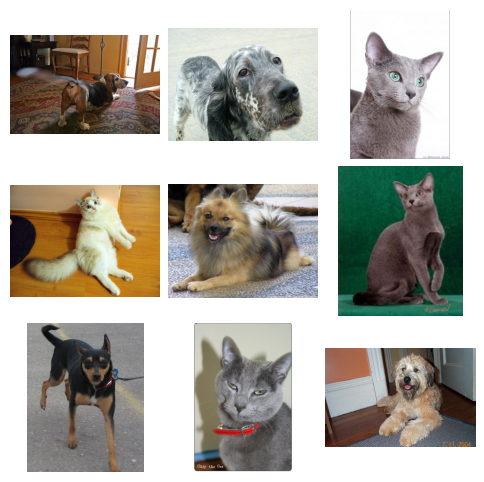

In [50]:
from matplotlib.colors import ListedColormap


def plot_imgs(imgs=None, masks=None, figsize=(12, 12), alpha=0.4):
    num_imgs = len(imgs or masks)
    nrows = int(math.ceil(math.sqrt(num_imgs)))
    ncols = int(math.ceil(num_imgs / nrows))
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten() if num_imgs > 1 else [axes]
    
    # Define segmentation colormap
    seg_colors = ['black', '#ff7f0e', '#1f77b4', '#ffdd00']
    seg_cmap = ListedColormap(seg_colors)
    
    for i, ax in enumerate(axes):
        if imgs is not None:
            img = imgs[i] * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)  # unnormalize
            ax.imshow(img.permute(1, 2, 0).numpy())
        
        if masks is not None:
            mask = masks[i].squeeze().numpy()  # Remove channel dimension if present
            ax.imshow(mask, cmap=seg_cmap, alpha=alpha, vmin=0, vmax=3)
        
        ax.axis('off')
    
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()


imgs, masks = map(list, zip(*[train_ds[i] for i in random.sample(range(len(train_ds)), 9)]))
plot_imgs(imgs, figsize=(6, 6))


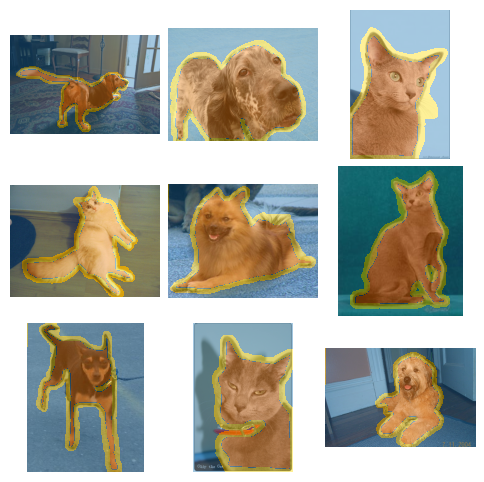

In [51]:
plot_imgs(imgs=imgs, masks=masks, figsize=(6, 6))

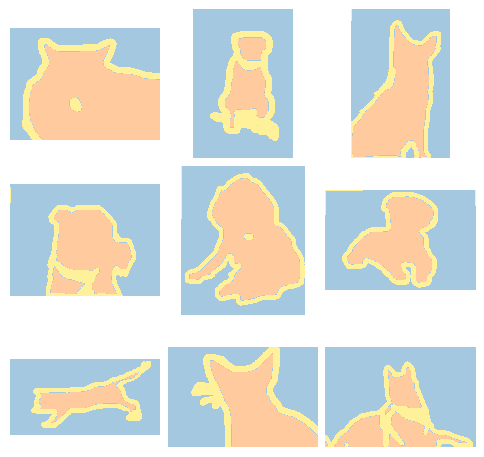

In [46]:
plot_imgs(masks=masks, figsize=(6, 6))

Before implementing a vision transformer, we need to represent images in a format the model can understand. This requires creating "patches" – dividing the image into many smaller, equal-sized chunks. By treating the image as a sequence of patches (read from left to right, like a book), the transformer can then imbibe the image data!

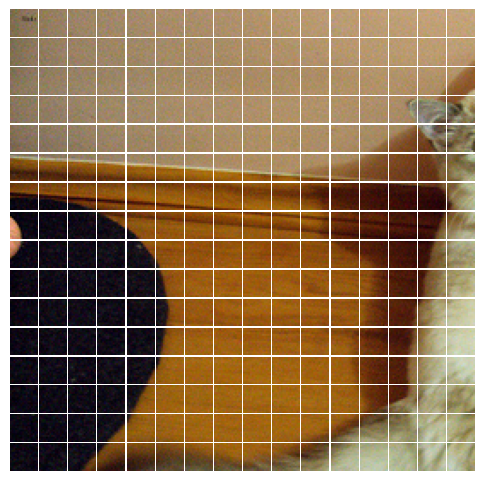

In [56]:
def extract_patches(imgs):
    if (unbatched := imgs.ndim == 3):
        imgs = imgs.unsqueeze(0)  # add batch dimension if it's not there

    B, C, H, W = imgs.size()

    patches = imgs.unfold(2, PATCH_SIZE, PATCH_SIZE)  # unfold along height
    patches = patches.unfold(3, PATCH_SIZE, PATCH_SIZE)  # unfold along width
    patches = patches.contiguous().view(B, C, -1, PATCH_SIZE, PATCH_SIZE)  # gather the different unfolds into 
    patches = patches.permute(0, 2, 1, 3, 4).contiguous()  # ensure the dimensions are in the right order before flattening
    patches = patches.view(B, -1, C * PATCH_SIZE * PATCH_SIZE)  # flatten
    
    return patches.squeeze(0) if unbatched else patches


cropped_img = imgs[3][..., :256, :256]  # smaller image so matplotlib doesn't freak out
plot_imgs(imgs=list(extract_patches(cropped_img).reshape(-1, 3, PATCH_SIZE, PATCH_SIZE)), figsize=(6, 6))

Our many images have differing sizes and patching 

So this is effectively what the transformer will see (except each patch will be flattened (along with the RGB dimension))

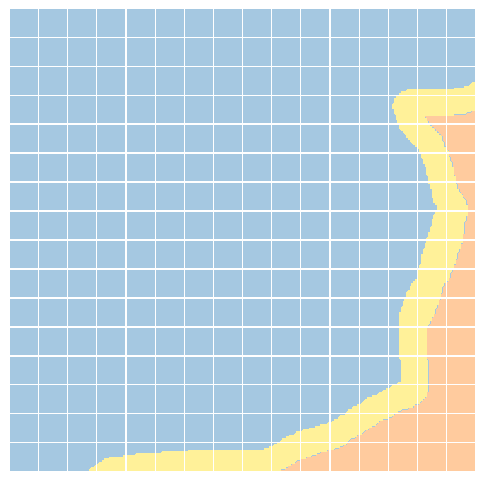

In [55]:
cropped_mask = masks[3][..., :256, :256]
plot_imgs(masks=list(extract_patches(cropped_mask).reshape(-1, 1, PATCH_SIZE, PATCH_SIZE)), figsize=(6, 6))

## 3. Data augmentations

- Useful since it effectively increases the size of our training dataset
- Necessary to crop the images to a sensible size since the largest would become a sequence of $22.500$ patches
    - Way to large to fit on a consumer grade graphics card
    - Therefore 

In [21]:
min([x.shape[-2] for x, _ in val_ds]), max([x.shape[-2] for x, _ in val_ds])

KeyboardInterrupt: 

In [ ]:
min([x.shape[-1] for x, _ in val_ds]), max([x.shape[-1] for x, _ in val_ds])

KeyboardInterrupt: 

In [ ]:
min([(x.shape[-1]//16) * (x.shape[-2]//16) * 3  for x, _ in val_ds]), max([(x.shape[-1]//16) * (x.shape[-2]//16) * 3  for x, _ in val_ds])

(189, 22500)